### Crank-Nicolson Method for Option Pricing

The Crank-Nicolson scheme is a finite-difference method used to numerically solve partial differential equations (PDEs). In option pricing, it is used to solve the Black-Scholes PDE for European options:

$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

This method is **unconditionally stable** and **second-order accurate** in both time and space, making it ideal for pricing options.

The PDE is discretized on a space-time grid, and the solution is obtained by solving a **tridiagonal system** at each time step. Boundary and initial conditions are applied to ensure correct behavior at \( t = T \) (maturity) and extreme values of stock price.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Parameters
S_max = 200      # Max stock price
K = 100          # Strike
T = 1.0          # Maturity
r = 0.05         # Risk-free rate
sigma = 0.2      # Volatility

M = 200          # Stock price steps
N = 1000         # Time steps

dS = S_max / M
dt = T / N

S = np.linspace(0, S_max, M+1)

In [2]:
# Option type: call
V = np.maximum(S - K, 0)   # Terminal condition at maturity

# Boundary conditions
def boundary_conditions(V):
    V[0] = 0                              # If S=0, call option value is 0
    V[-1] = S_max - K * np.exp(-r * dt)  # Linear approximation at S_max
    return V

In [3]:
# Coefficients
i = np.arange(1, M)
alpha = 0.25 * dt * (sigma**2 * i**2 - r * i)
beta  = -0.5 * dt * (sigma**2 * i**2 + r)
gamma = 0.25 * dt * (sigma**2 * i**2 + r * i)

# A matrix (LHS)
A_lower = -alpha
A_diag  = 1 - beta
A_upper = -gamma

# B matrix (RHS)
B_lower = alpha
B_diag  = 1 + beta
B_upper = gamma

In [4]:
# Preallocate solution
V_prev = V.copy()

# Tridiagonal matrix representation for solve_banded
ab = np.zeros((3, M-1))

for n in range(N):
    # Right-hand side
    rhs = B_lower * V_prev[:-2] + B_diag * V_prev[1:-1] + B_upper * V_prev[2:]

    # Apply boundary conditions
    rhs[0]   += alpha[0] * V_prev[0]
    rhs[-1]  += gamma[-1] * V_prev[-1]

    # Fill the banded matrix
    ab[0, 1:] = A_upper[:-1]  # Upper diagonal
    ab[1, :]  = A_diag        # Main diagonal
    ab[2, :-1] = A_lower[1:]  # Lower diagonal

    # Solve
    V_interior = solve_banded((1, 1), ab, rhs)

    # Update full solution
    V_prev[1:-1] = V_interior
    V_prev = boundary_conditions(V_prev)

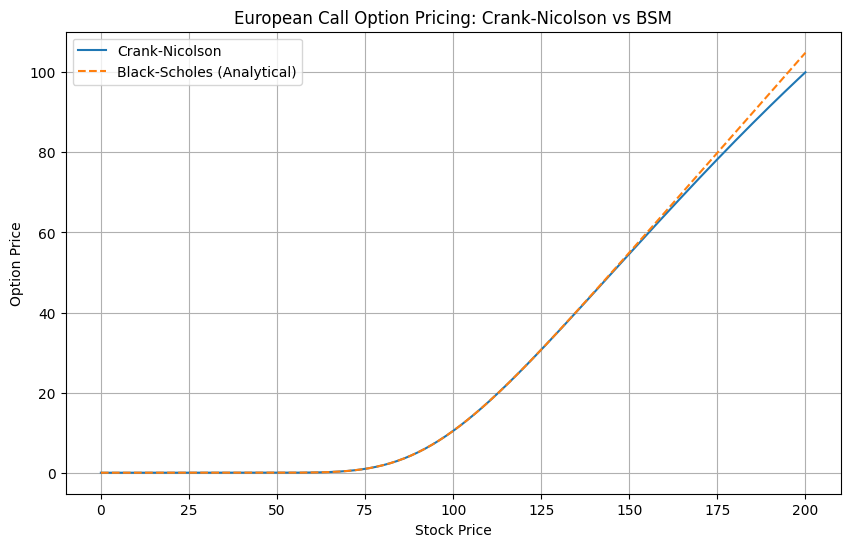

In [10]:
from scipy.stats import norm

def bs_call_price(S, K, T, r, sigma):
    def safe_d1(S, K, T, r, sigma):
        epsilon = 1e-10  # to prevent division or log of zero
        S = np.maximum(S, epsilon)
        K = np.maximum(K, epsilon)
        T = np.maximum(T, epsilon)
        sigma = np.maximum(sigma, epsilon)

        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return d1, d2
    d1, d2 = safe_d1(S, K, T, r, sigma)
    return S * norm.cdf(d1) - K*np.exp(-r*T) * norm.cdf(d2)

# Plotting
bs_prices = bs_call_price(S, K, T, r, sigma)

plt.figure(figsize=(10,6))
plt.plot(S, V_prev, label='Crank-Nicolson')
plt.plot(S, bs_prices, '--', label='Black-Scholes (Analytical)')
plt.xlabel('Stock Price')
plt.ylabel('Option Price')
plt.title('European Call Option Pricing: Crank-Nicolson vs BSM')
plt.legend()
plt.grid(True)
plt.show()

### Finite Difference Method – Crank-Nicolson for Vanilla European Options

This notebook implements the Crank-Nicolson finite difference scheme for solving the Black-Scholes partial differential equation. The Crank-Nicolson method is:
- **Second-order accurate** in both space and time
- **Unconditionally stable** (unlike explicit Euler)

We discretize the PDE over a space-time grid, apply boundary and terminal conditions, and solve a tridiagonal linear system at each time step using `scipy.linalg.solve_banded`.

Results are validated against Black-Scholes analytical prices.